In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import resample
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('Admission_Predict.csv')
df

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
395,396,324,110,3,3.5,3.5,9.04,1,0.82
396,397,325,107,3,3.0,3.5,9.11,1,0.84
397,398,330,116,4,5.0,4.5,9.45,1,0.91
398,399,312,103,3,3.5,4.0,8.78,0,0.67


In [4]:
df.columns = df.columns.str.strip()
threshold = df['Chance of Admit'].describe()['75%']
threshold

0.83

In [5]:
df['Admitted'] = (df['Chance of Admit']>= threshold).astype(int)
df.drop(['Chance of Admit'],axis=1)
counts = df['Admitted'].value_counts()
counts

0    299
1    101
Name: Admitted, dtype: int64

In [6]:
df_majority = df[df['Admitted']==0]
df_minority = df[df['Admitted']==1]

df_sampled = resample(df_minority,replace=True,n_samples=len(df_majority),random_state=42)
df_balanced = pd.concat([df_majority,df_sampled])
df_balanced['Admitted'].value_counts()

0    299
1    299
Name: Admitted, dtype: int64

In [7]:
x = df[['GRE Score','LOR','CGPA']]
y = df[['Admitted']]

df_balanced = df_balanced[['GRE Score', 'LOR', 'CGPA', 'Admitted']]

df_balanced.head()

,GRE Score,LOR,CGPA,Admitted
1,324,4.5,8.87,0
2,316,3.5,8.00,0
3,322,2.5,8.67,0
4,314,3.0,8.21,0
6,321,4.0,8.20,0


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.25,random_state=1)

Criterion: gini
Training Accuracy: 0.9533333333333334
Training Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       224
           1       0.90      0.92      0.91        76

    accuracy                           0.95       300
   macro avg       0.94      0.94      0.94       300
weighted avg       0.95      0.95      0.95       300

Testing Accuracy: 0.92
Testing Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        75
           1       0.84      0.84      0.84        25

    accuracy                           0.92       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.92      0.92      0.92       100



AttributeError: 'str' object has no attribute 'items'

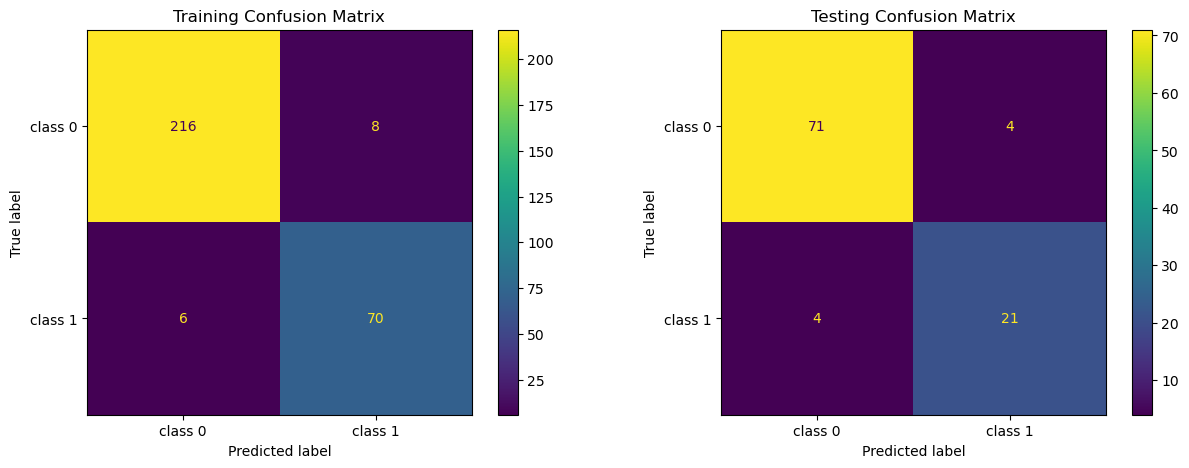

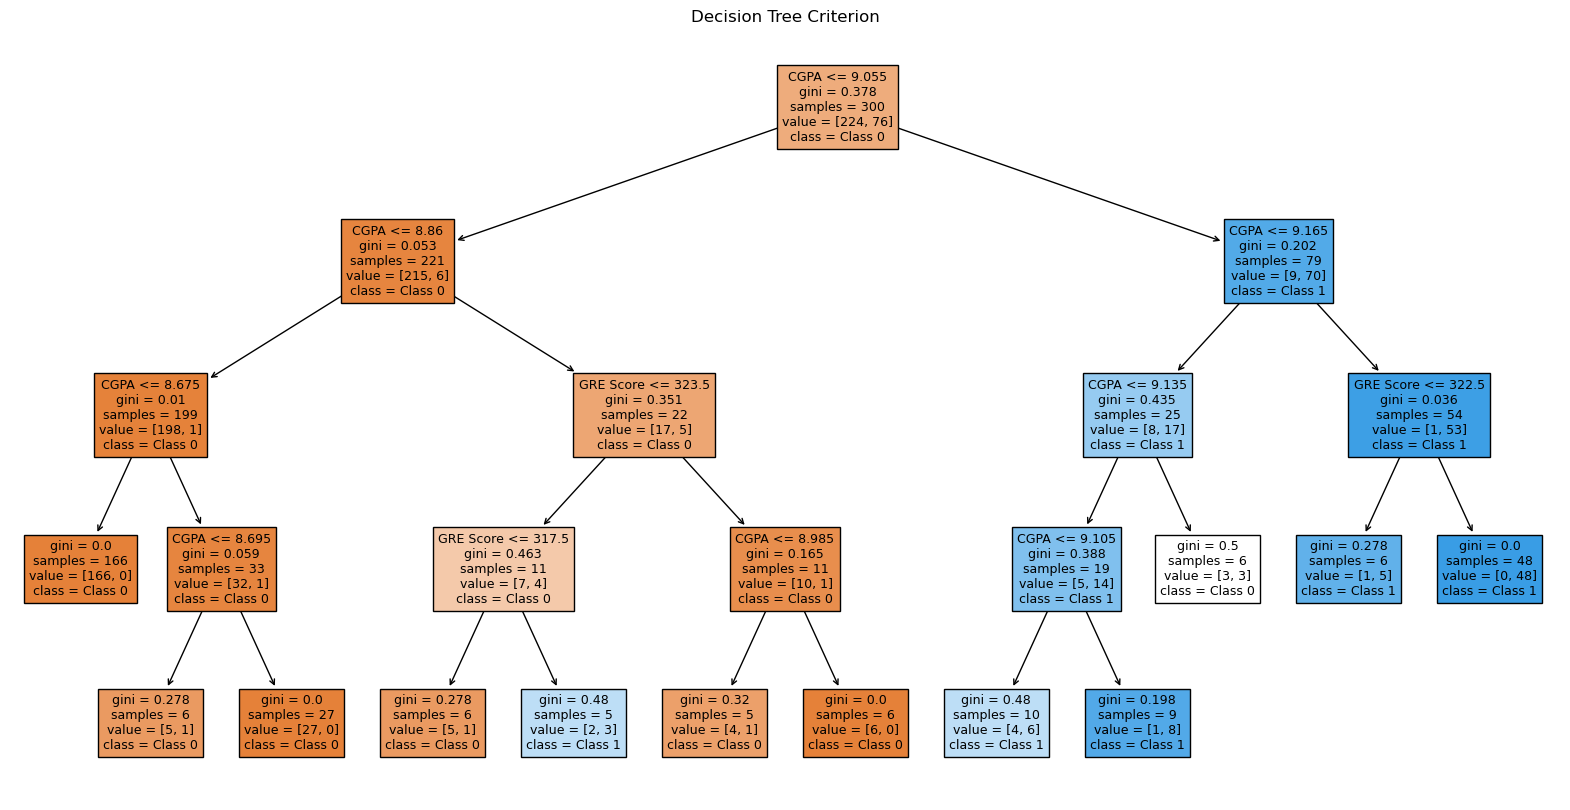

In [10]:
def display_results(results, x_train, y_train, x_test, y_test):
    # Display evaluation metrics
    print("Criterion:", results['criterion'])
    print("Training Accuracy:", results['train_accuracy'])
    print("Training Classification Report:\n", results['train_report'])

    print("Testing Accuracy:", results['test_accuracy'])
    print("Testing Classification Report:\n", results['test_report'])

    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ConfusionMatrixDisplay.from_estimator(
        results['model'],
        x_train,
        y_train,
        ax=ax1,
        display_labels = ['class 0','class 1'],        
    )
    ax1.set_title("Training Confusion Matrix")
    
    ConfusionMatrixDisplay.from_estimator(
        results['model'],
        x_test,
        y_test,
        ax=ax2,
        display_labels = ['class 0','class 1'],
    )
    ax2.set_title("Testing Confusion Matrix")
    
    plt.figure(figsize=(20, 10))  
    tree.plot_tree(
        results['model'],
        filled=True,           
        feature_names=x_train.columns.tolist(), 
        class_names=['Class 0', 'Class 1'], 
    )

    plt.title("Decision Tree Criterion",results['criterion'])

def train_and_evaluate_pruned(criterion, x_train, y_train, x_test, y_test):
    # Adjusting parameters to prune the tree
    model = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=4,               # Set a maximum depth to control tree size
        min_samples_split=10,      # Minimum samples needed to split a node
        min_samples_leaf=5,        # Minimum samples needed at a leaf node
        random_state=14
    )
    model.fit(x_train, y_train)

    # Predict on training and testing data
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    # Evaluation metrics for training data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_conf_matrix = confusion_matrix(y_train, y_train_pred)
    train_report = classification_report(y_train, y_train_pred)

    # Evaluation metrics for testing data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)
    test_report = classification_report(y_test, y_test_pred)

    return {
        "criterion": criterion,
        "model": model,
        "train_accuracy": train_accuracy,
        "train_conf_matrix": train_conf_matrix,
        "train_report": train_report,
        "test_accuracy": test_accuracy,
        "test_conf_matrix": test_conf_matrix,
        "test_report": test_report,
    }

pruned_gini_results = train_and_evaluate_pruned('gini', x_train, y_train, x_test, y_test)
display_results(pruned_gini_results, x_train, y_train, x_test, y_test)
    